In [6]:
import numpy as np
import math
from matplotlib import cm
import matplotlib.pyplot as plt

case = ['h5','h8','h10']
file = ['10000','10000','10000']
head ='/home/haoyan/Desktop/ML-CFD/CASE/PHill/Grid-iretation-independency/'
i = [70,93,140]
j = [65,83,150]
number = [70*65,93*83,140*150]

In [7]:
def reading_field(head,name,n_package,file_name,i,j):#Reading the raw vector data
    file = head +name +'/'+ n_package + '/' + file_name
    raw_data = []
    number = (i * j)
    with open(file) as f:
        for line in f:
            line = line.strip('\n')
            raw_data.append(line)
    data_str = (raw_data[23:(23+number)])
    data  = [float(i) for i in data_str]
    data = np.array(data)
    return data

def reading_U(head,name,n_package,file_name,i,j): # Reading second-rank tensor in OpenFoam field
    file = head +name +'/'+ n_package + '/' + file_name
    raw_data = []
    number = (i * j)
    with open(file) as f:
        for line in f:
            line = line.strip('\n ()')
            raw_data.append(line)
    data_str = raw_data[23:(23+number)]
    tensors = np.zeros((number,3))
    for i in range(number):
        element = np.array([float(i) for i in data_str[i].split()])
        tensors[i] = element
    U = tensors[:,0]
    V = tensors[:,1]
    return U,V

def grid_plot(x,y):#Drawing the scatter of mesh centres
    plt.figure(figsize=(90,30.35))
    plt.scatter(x,y,color='k')
    plt.xlabel('x')
    plt.ylabel('y')
    
def reading_tensors(head,name,n_package,file_name,i,j): # Reading second-rank tensor in OpenFoam field
    raw_data = []
    file = head +name +'/'+ n_package + '/' + file_name
    number = (i * j)
    with open(file) as f:
        for line in f:
            line = line.strip('\n ()')
            raw_data.append(line)
    data_str = raw_data[23:(23+number)]
    tensors = np.zeros((number,3,3))
    for i in range(number):
        element = np.array([float(i) for i in data_str[i].split()])
        element = element.reshape((3,3))
        tensors[i] = element
    return tensors

def reading_R(head,name,n_package,file_name,i,j): # Reading second-rank tensor in OpenFoam field
    raw_data = []
    file = head +name +'/'+ n_package + '/' + file_name
    number = (i * j)
    with open(file) as f:
        for line in f:
            line = line.strip('\n ()')
            raw_data.append(line)
    data_str = raw_data[23:(23+number)]
    tensors = np.zeros((number,6))
    for i in range(number):
        element = np.array([float(i) for i in data_str[i].split()])
        tensors[i] = element
    return tensors

def Stra_Rota(tensor,k,epsilon):#Forming non-dimensional strain tensor and rotation tensor
    number = len(tensor)
    s = np.zeros((number,3,3))
    w = np.zeros((number,3,3))
    for i in range(number):
        coef = k[i] / epsilon[i]
        s[i] = coef * (tensor[i] + tensor[i].T)/2
        w[i] = coef * (tensor[i] - tensor[i].T)/2
        #s[i][0][2],s[i][2][0],s[i][1][2],s[i][2][1] = 0.0
        #w[i][0][2],w[i][2][0],w[i][1][2],w[i][2][1] = 0.0
        s[i][0][2] = 0.0
        s[i][2][0] = 0.0
        s[i][1][2] = 0.0
        s[i][2][1] = 0.0
        w[i][0][2] = 0.0
        w[i][2][0] = 0.0
        w[i][1][2] = 0.0
        w[i][2][1] = 0.0
    return s,w

def Epsilon(omega,k):
    ep = []
    for i in range(len(omega)):
        ep.append(0.09*omega[i]*k[i])
    #ep = np.array(ep)
    return ep

def Invariants(s,w):#Forming 5 Invariants according to Pope(1975)
    number = len(s)
    l_1 = np.zeros(number)
    l_2 = np.zeros(number)
    l_3 = np.zeros(number)
    l_4 = np.zeros(number)
    l_5 = np.zeros(number)
    for i in range(number):
        tmp_1 = s[i]@s[i]
        tmp_2 = w[i]@w[i]
        tmp_3 = s[i]@s[i]@s[i]
        tmp_4 = w[i]@w[i]@s[i]
        tmp_5 = w[i]@w[i]@s[i]@s[i]
        l_1[i] = tmp_1.trace()
        l_2[i] = tmp_2.trace()
        l_3[i] = tmp_3.trace()
        l_4[i] = tmp_4.trace()
        l_5[i] = tmp_5.trace()
    return l_1,l_2,l_3,l_4,l_5

def General_Tensors(s,w):#Forming 10 general tensors according to Pope(1975)
    number = len(s)
    T_1 = np.zeros((number,3,3))
    T_2 = np.zeros((number,3,3))
    T_3 = np.zeros((number,3,3))
    T_4 = np.zeros((number,3,3))
    T_5 = np.zeros((number,3,3))
    T_6 = np.zeros((number,3,3))
    T_7 = np.zeros((number,3,3))
    T_8 = np.zeros((number,3,3))
    T_9 = np.zeros((number,3,3))
    T_10 = np.zeros((number,3,3))
    for i in range(number):
        tmp_1 = s[i]@s[i]
        tmp_2 = w[i]@w[i]
        tmp_3 = s[i]@w[i]@w[i]
        tmp_4 = s[i]@s[i]@w[i]@w[i]
        T_1[i] = s[i]
        T_2[i] = s[i]@w[i] - w[i]@s[i]
        T_3[i] = s[i]@s[i] - (1/3) * np.eye(3) * tmp_1.trace() 
        T_4[i] = w[i]@w[i] - (1/3) * np.eye(3) * tmp_2.trace()
        T_5[i] = w[i]@s[i]@s[i] - s[i]@s[i]@w[i]
        T_6[i] = w[i]@w[i]@s[i] + s[i]@w[i]@w[i] - (2/3) * np.eye(3) * tmp_3.trace()
        T_7[i] = w[i]@s[i]@w[i]@w[i] - w[i]@w[i]@s[i]@w[i]
        T_8[i] = s[i]@w[i]@s[i]@s[i] - s[i]@s[i]@w[i]@s[i]
        T_9[i] = w[i]@w[i]@s[i]@s[i] + s[i]@s[i]@w[i]@w[i] - 2/3 * np.eye(3)*tmp_4.trace()
        T_10[i] = w[i]@s[i]@s[i]@w[i]@w[i] - w[i]@w[i]@s[i]@s[i]@w[i]
    return T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9,T_10

def plot_contour_2(x_coordinate,y_coordinate,i,j,field,field_name,bar_numbers,Min,Max):
    X = np.zeros((j,i))
    Y = np.zeros((j,i))
    Field = np.zeros((j,i))
    x_coordinate = x_coordinate * 1000 / 28
    y_coordinate = y_coordinate * 1000 / 28
    for n in range(j):
        X[n,:] = x_coordinate[i*n:i*(n+1)]
        Y[n,:] = y_coordinate[i*n:i*(n+1)]
        Field[n,:] = field[i*n:i*(n+1)]
    fig,ax = plt.subplots(figsize=(25,7.5))
    levels = list(np.linspace(Min,Max,bar_numbers))
    p1 = ax.contourf(X,Y,Field,levels,cmap=cm.jet,extend='both')
    p2 = ax.contour(X,Y,Field,levels,linewidths=0.5,colors='black',extend='both')
    ax.set_xlim(min(x_coordinate), max(x_coordinate))
    ax.set_ylim(min(y_coordinate), max(y_coordinate))
    ax.set_xlabel("$\t{x}$",size=15)
    ax.set_ylabel("$\t{y}$",size=15)
    cbar = fig.colorbar(p1)
    cbar.set_label(field_name, size=18)
    plt.show()
    return 0

def Cal_anisotropy(uu,uv,uw,vv,vw,ww,k):
    B_11 = np.zeros(len(uu))
    B_22 = np.zeros(len(uu))
    B_33 = np.zeros(len(uu))
    B_12 = np.zeros(len(uu))
    B_13 = np.zeros(len(uu))
    B_23 = np.zeros(len(uu))
    for i in range(len(uu)):
        B_11[i] = uu[i]/(2*k[i]) - 1/3
        B_12[i] = uv[i]/(2*k[i]) 
        #B_13[i] = uw[i]/(2*k[i]) Not needed for two-dimensional cases
        B_22[i] = vv[i]/(2*k[i]) - 1/3
        #B_23[i] = vw[i]/(2*k[i])
        B_33[i] = ww[i]/(2*k[i]) - 1/3
    return B_11,B_12,B_13,B_22,B_23,B_33

In [8]:
x = reading_field(head,case[2],file[2],'Cx',i[2],j[2])
y = reading_field(head,case[2],file[2],'Cy',i[2],j[2])
k = reading_field(head,case[2],file[2],'k',i[2],j[2])
omega = reading_field(head,case[2],file[2],'omega',i[2],j[2])
epsilon = Epsilon(omega,k)
U,V = reading_U(head,case[2],file[2],'U',i[2],j[2])
#Tau_t = np.array([k[i]/epsilon[i] for i in range(25088)])
Grad_U = reading_tensors(head,case[2],file[2],'grad(U)',i[2],j[2])
R = reading_R(head,case[2],file[2],'UPrime2Mean',i[2],j[2])
s,w = Stra_Rota(Grad_U,k,epsilon)#stress tensor, rotation tensor
I_1,I_2,I_3,I_4,I_5 = Invariants(s,w) #Invariants//verified
T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9,T_10 = General_Tensors(s,w)

In [9]:
I_all = np.column_stack((I_1[0:(140*100)],I_2[0:(140*100)],I_3[0:(140*100)],I_4[0:(140*100)],I_5[0:(140*100)]))
I = np.column_stack((I_1[0:number[2]],I_2[0:number[2]],I_3[0:number[2]],I_4[0:number[2]],I_5[0:number[2]]))
Tensors_all = np.zeros(((140*100),10,3,3))
Tensors = np.zeros((number[2],10,3,3))
for i in range(((140*100))):
    Tensors_all[i][0] = T_1[i]
    Tensors_all[i][1] = T_2[i]
    Tensors_all[i][2] = T_3[i]
    Tensors_all[i][3] = T_4[i]
    Tensors_all[i][4] = T_5[i]
    Tensors_all[i][5] = T_6[i]
    Tensors_all[i][6] = T_7[i]
    Tensors_all[i][7] = T_8[i]
    Tensors_all[i][8] = T_9[i]
    Tensors_all[i][9] = T_10[i] 
for i in range(number[2]):
    Tensors[i][0] = T_1[i]
    Tensors[i][1] = T_2[i]
    Tensors[i][2] = T_3[i]
    Tensors[i][3] = T_4[i]
    Tensors[i][4] = T_5[i]
    Tensors[i][5] = T_6[i]
    Tensors[i][6] = T_7[i]
    Tensors[i][7] = T_8[i]
    Tensors[i][8] = T_9[i]
    Tensors[i][9] = T_10[i]
    
uu = R[:,0]
uv = R[:,1]
uw = R[:,2]
vv = R[:,3]
vw = R[:,4]
ww = R[:,5]
R_b_11,R_b_12,R_b_13,R_b_22,R_b_23,R_b_33 = Cal_anisotropy(uu,uv,uw,vv,vw,ww,k)

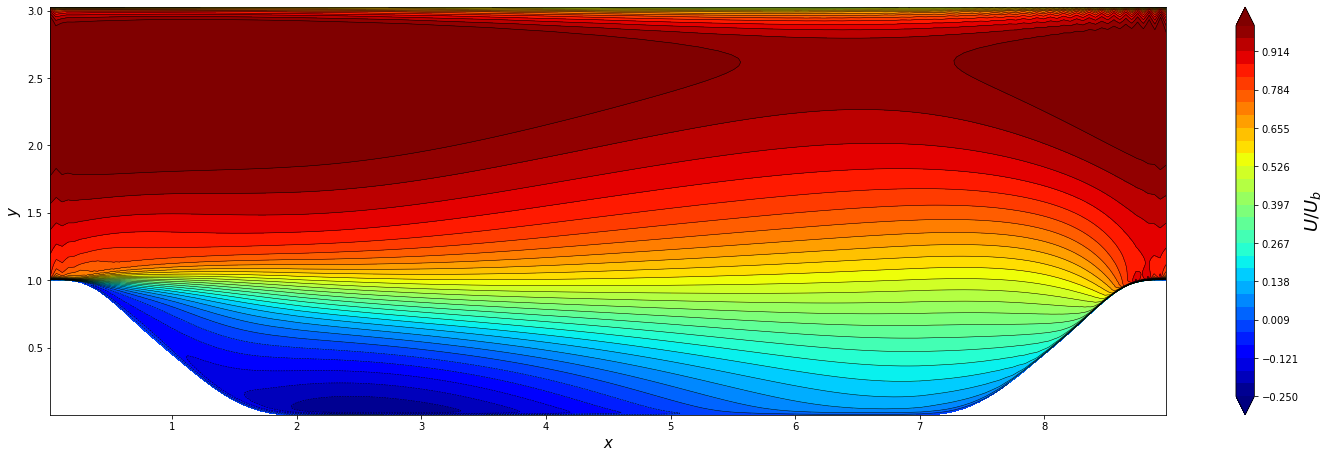

0

In [10]:
i = [70,93,140]
j = [65,83,150]
plot_contour_2(x,y,i[2],j[2],U,'$U/U_{b}$',30,-0.25,1.0)

In [11]:
np.save("/home/haoyan/Desktop/ML-CFD/CASE/PHill/TBNN/Invariants_RANS.npy",I_all)
np.save("/home/haoyan/Desktop/ML-CFD/CASE/PHill/TBNN/Invariants.npy",I)
np.save("/home/haoyan/Desktop/ML-CFD/CASE/PHill/TBNN/Tensors_RANS.npy",Tensors_all)
np.save("/home/haoyan/Desktop/ML-CFD/CASE/PHill/TBNN/Tensors.npy",Tensors)